<a href="https://colab.research.google.com/github/chetan015/tf-federated/blob/master/tffMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Federated Training on MNIST Dataset implementation using the high level Federated Learning (FL) API of TensorFlow Federated (TFF).  
[Go to Source](https://www.tensorflow.org/federated/tutorials/federated_learning_for_image_classification)

Ensure the environment is setup correctly

In [86]:

!pip install --quiet --upgrade tensorflow_federated

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Import collections, numpy, TensorFlow and TFF libraries

In [87]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from matplotlib import pyplot as plt

np.random.seed(0)

Define Constants to be used

In [88]:
NUM_CLIENTS = 10 #@param {type:"integer"}
NUM_EPOCHS = 5 #@param {type:"integer"}
BATCH_SIZE = 20 #@param {type:"integer"}
SHUFFLE_BUFFER = 100 #@param {type:"integer"}
PREFETCH_BUFFER=10 #@param {type:"integer"}

Data Preparation
The TFF library has a federated version of the classic MNIST digits image dataset. Using, [LEAF](https://github.com/TalwalkarLab/leaf), the original dataset has been partitioned as per the original writers of the digits. This is typical of a federated setting, where the on device data is non IID.  

In [89]:
# Load Dataset as train and test sets
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

/usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:63: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


emnist_train and emnist_test are instances of tff.simulation.ClientData, which allows enumeration of set of users, construction of a tf.data.Dataset for each client/user and query structure of individual elements. It is an object to hold a dataset and a mapping of clients to examples. This can be verified by the code snippet below.

There are 3383 Client ids. The dataset comprises images of size 28x28.

In [90]:
print(type(emnist_train))
print(len(emnist_train.client_ids))
print(emnist_train.element_type_structure)

<class 'tensorflow_federated.python.simulation.hdf5_client_data.HDF5ClientData'>
3383
OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)), ('pixels', TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])


Let's create a sample client dataset and inspect a random image and its label 

/usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:63: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


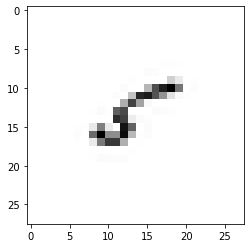

In [91]:
example_dataset = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[0])
example_element = next(iter(example_dataset))
example_element['label'].numpy()

plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

Dataset Preprocessing: Each 28x28 image is flattened to a 784 element array, the individual examples are shuffled and organized into batches. The features 'pixels' and 'label' are renamed to 'x' and 'y'

In [92]:
def preprocess(dataset):

  def batch_format_fn(element):
    """Flatten a batch `pixels` and return the features as an `OrderedDict`."""
    return collections.OrderedDict(
        x=tf.reshape(element['pixels'], [-1, 784]),
        y=tf.reshape(element['label'], [-1, 1]))

  return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [93]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x', array([[1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     ...,
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.],
                     [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)),
             ('y', array([[9],
                     [1],
                     [7],
                     [1],
                     [3],
                     [0],
                     [2],
                     [2],
                     [6],
                     [3],
                     [4],
                     [7],
                     [1],
                     [2],
                     [6],
                     [6],
                     [4],
                     [1],
                     [0],
                     [0]], dtype=int32))])

A helper function to construct a list of datasets from provided list of clients. Since this is a simulation, we are creating and partioning the dataset. In actual federated setting, the dataset would be locally available with each client, undiscoverable and inaccessible externally.

In [94]:
def make_federated_data(client_data, client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

While there may be hundreds or thousands of clients available, only a subset of these are selected for participation in the Federated Averaging algorithm. This simulation samples the set of clients and reuses the same set across rounds.

In [95]:
sample_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, sample_clients)

print('Number of client datasets: {l}'.format(l=len(federated_train_data)))
print('First dataset: {d}'.format(d=federated_train_data[0]))

Number of client datasets: 10
First dataset: <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>


/usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:63: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


Model creation with Keras

In [96]:
def create_keras_model():
  return tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(784,)),
      tf.keras.layers.Reshape((28,28,1),input_shape = (784,)),
      tf.keras.layers.Conv2D(8, 3, activation='relu', input_shape=(28,28,1)), #26
      tf.keras.layers.Conv2D(16, 3, activation='relu'), #24
      tf.keras.layers.Conv2D(32, 3, activation='relu'), #22
      tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), #11
      tf.keras.layers.Conv2D(8,1,activation='relu'), 
      tf.keras.layers.Conv2D(16, 3, activation='relu'), #9
      tf.keras.layers.Conv2D(32, 3, activation='relu'), #7
      tf.keras.layers.Conv2D(32, 1, activation='relu'), #7
      tf.keras.layers.Conv2D(10, 7),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Activation('softmax'),
  ])

In [97]:
model = create_keras_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 26, 26, 8)         80        
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 24, 24, 16)        1168      
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 22, 22, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 11, 11, 8)         264       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 9, 9, 16)         

The TFF model function helper calls the keras model creation helper. This model needs to be wrapped in an instance of `tff.learning.Model` interface. This interface, similar to Keras, exposes methods to stamp the forward pass, metadata and metrics among others, and also introduces elements to support the federated environment, like ways to control computation of federated metric.

In [98]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

Model Training on Federated data

The `tff.learning.build_federated_averaging_process` helper function helps construct a Federated Averagin algorithm for model training. The optimizer here differs from that we are used to. There are two optimizers: clientoptimizer and serveroptimizer, since the model training happens on device, and the global model trains with the average update of client models as well. To start with, regular SGD with small learning rate is used. 

In [99]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.1),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0))

By calling `build_federated_averaging_process`, TFF has constructed a pair of federated computations and packaged them into a `tff.templates.IterativeProcess`, in which these computations are available as a pair of properties `initialize` and `next`. TFF only supports local execution simulation runtime for now. The `initialize` computation is like a function that does not take any arguments, but returns the state representation of the Federated Averaging process on the server. Invoking it constructs the server state

In [100]:
print(str(iterative_process.initialize.type_signature))
state = iterative_process.initialize()

( -> <model=<trainable=<float32[3,3,1,8],float32[8],float32[3,3,8,16],float32[16],float32[3,3,16,32],float32[32],float32[1,1,32,8],float32[8],float32[3,3,8,16],float32[16],float32[3,3,16,32],float32[32],float32[1,1,32,32],float32[32],float32[7,7,32,10],float32[10]>,non_trainable=<>>,optimizer_state=<int64>,delta_aggregate_state=<>,model_broadcast_state=<>>@SERVER)


The `next` computation represents one round of Federated Averaging, which involves:
1. Push server state with the global model parameters to the clients.
2. On device training with local data.
3. Aggregation and averaging of model updates from clients.
4. Producing new updated model at server.

next() should be considered not as a function running on server, but as a declarative functional representation of the entire decentralized computation.

Conducting 10 rounds of federated training:

In [101]:
NUM_ROUNDS = 11
for round_num in range(1, NUM_ROUNDS):
  state, metrics = iterative_process.next(state, federated_train_data)
  print('round {:2d}, metrics={}'.format(round_num, metrics))

round  1, metrics=<sparse_categorical_accuracy=0.12016461044549942,loss=2.298546314239502>
round  2, metrics=<sparse_categorical_accuracy=0.13806584477424622,loss=2.2908363342285156>
round  3, metrics=<sparse_categorical_accuracy=0.17366255819797516,loss=2.26645565032959>
round  4, metrics=<sparse_categorical_accuracy=0.24588477611541748,loss=2.1862783432006836>
round  5, metrics=<sparse_categorical_accuracy=0.39444443583488464,loss=1.947983741760254>
round  6, metrics=<sparse_categorical_accuracy=0.6921810507774353,loss=1.0725432634353638>
round  7, metrics=<sparse_categorical_accuracy=0.78847736120224,loss=0.7530097961425781>
round  8, metrics=<sparse_categorical_accuracy=0.8343621492385864,loss=0.5935142636299133>
round  9, metrics=<sparse_categorical_accuracy=0.9055555462837219,loss=0.3236108124256134>
round 10, metrics=<sparse_categorical_accuracy=0.9253086447715759,loss=0.28766554594039917>


The metrics displayed with the rounds represent training metrics. To perform evaluation, another federated computation can be defined using `tff.learning.build_federated_evaluation` function, and passing in the model constructor as argument. Evaluation only involves inference on the test data set, and hence doesn't require constructing optimizers.

In [102]:
evaluation = tff.learning.build_federated_evaluation(model_fn)
print(str(evaluation.type_signature))

(<<trainable=<float32[3,3,1,8],float32[8],float32[3,3,8,16],float32[16],float32[3,3,16,32],float32[32],float32[1,1,32,8],float32[8],float32[3,3,8,16],float32[16],float32[3,3,16,32],float32[32],float32[1,1,32,32],float32[32],float32[7,7,32,10],float32[10]>,non_trainable=<>>@SERVER,{<x=float32[?,784],y=int32[?,1]>*}@CLIENTS> -> <sparse_categorical_accuracy=float32@SERVER,loss=float32@SERVER>)


In [103]:
train_metrics = evaluation(state.model, federated_train_data)
str(train_metrics)

'<sparse_categorical_accuracy=0.8868312835693359,loss=0.4424940347671509>'

In [104]:
federated_test_data = make_federated_data(emnist_test, sample_clients)

len(federated_test_data), federated_test_data[0]

/usr/local/lib/python3.6/dist-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:63: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


(10,
 <PrefetchDataset shapes: OrderedDict([(x, (None, 784)), (y, (None, 1))]), types: OrderedDict([(x, tf.float32), (y, tf.int32)])>)

In [105]:
test_metrics = evaluation(state.model, federated_test_data)
str(test_metrics)

'<sparse_categorical_accuracy=0.8620689511299133,loss=0.4663618505001068>'

We have obtained 86% accuracy on test dataset with 10 rounds of federated averaging algorithm.